In [1]:
import pandas as pd
import numpy as np
import csv
import os
from os import path
import weblogo
import seqlogo
np.random.seed(42)

In [2]:
filteredGeneList = pd.read_csv('../../Database/filteredGenesDetails_human_240118.txt',sep='\t')

In [3]:
acc2gene={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']

In [4]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [5]:
splicedGenes = get_fa('../../Database/splicedGenes_240118.txt')
print(type(splicedGenes))
print(list(splicedGenes.keys())[0:3])

<class 'dict'>
['NR_148357_chr1(+):11868-14361', 'NR_046018_chr1(+):11873-14408', 'NR_024540_chr1(-):14361-29369']


In [6]:
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
print(type(splicedGenes))
print(list(splicedGenes.keys())[0:3])

<class 'dict'>
['NR_148357', 'NR_046018', 'NR_024540']


In [7]:
splicedORFs = get_fa('../../Database/splicedORFs_240118.txt')
print(type(splicedORFs))
print(list(splicedORFs.keys())[0:3])

<class 'dict'>
['NM_017582', 'NM_001276267', 'NM_173469']


In [8]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

## Stats

#### helper funcs

In [9]:
def genes2seq(genes):
    seqs = []
    for gene in genes:
        fp=fpUTR[gene]
        if len(fp)<8:
            #print('No fpUTR encountered: ',acc2gene[gene])
            continue
        seq = fp[-8:]+ORFs[gene][:11]
        seqs.append(seq)
    print('# of valid seqs: ',len(seqs))
    return seqs

In [10]:
def seqs2count(seqs,seqLen=19):
    raw_count = np.zeros((seqLen,4))
    lines_tr=[''.join(s) for s in zip(*seqs)]
    #print('#lines = ',len(seqs))
    for i in range(seqLen):
        raw_count[i][0] = lines_tr[i].count('A')
        raw_count[i][1] = lines_tr[i].count('C')
        raw_count[i][2] = lines_tr[i].count('G')
        raw_count[i][3] = lines_tr[i].count('T')
    return raw_count,pfm2ppm(raw_count)

In [91]:
def plotlogo(raw_count,datset=None):
    pfm_pd=pd.DataFrame(raw_count)
    ppm_pd=seqlogo.pfm2ppm(pfm_pd)
    ppm = seqlogo.Ppm(ppm_pd)
    plt=seqlogo.seqlogo(ppm, ic_scale = False, format = 'png', size = 'medium')#,filename=datset+'.png')
    #seqlogo.seqlogo(ppm, ic_scale = True, format = 'svg', size = 'medium')#,filename=datset+'.svg')
    return plt

In [12]:
def pfm2ppm(pfm):
    sum_of_rows = pfm.sum(axis=1)
    return pfm / sum_of_rows[:, np.newaxis]

In [74]:
deseq = pd.read_csv('../../Deseq2 Analysis/shift15/coding/csv_raw/ER_S15_t1.csv')
deseq = deseq.sort_values(by=['log2FoldChange'])
print(len(deseq))
deseq.head(2)

7990


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4704,NM_001030001,302.88160,-1.680914,0.556766,-3.019064,0.002536,0.021744
7304,NM_001300954,57.22634,-1.416071,0.536922,-2.637386,0.008355,0.051909


In [75]:
background = deseq['Unnamed: 0']
deseq_filtered = deseq.loc[deseq['padj']<0.05]
up_num = sum(deseq_filtered['log2FoldChange'] > 1)
target = deseq_filtered.tail(up_num)['Unnamed: 0']   # i.e. Interest group, upper right on volcano plot

In [76]:
target_seqs = genes2seq(target)
bg_seqs = genes2seq(background)

# of valid seqs:  177
# of valid seqs:  7890


In [77]:
target_pfm, target_ppm = seqs2count(target_seqs)
bg_pfm, bg_ppm = seqs2count(bg_seqs)

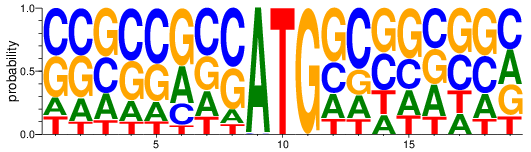

In [92]:
%matplotlib inline
a=plotlogo(target_pfm)
display(a)

In [79]:
def ppm2flat(ppm):
    return ppm[list(range(0,8))+list(range(11,19)), 0:4].reshape(-1)

target_flat = ppm2flat(target_ppm)
bg_flat = ppm2flat(bg_ppm)*len(target_seqs)

In [80]:
len(sample_flat)

64

In [81]:
from scipy.stats import chisquare

In [82]:
def bootstrap(seqs,num):    
    sample_seqs = np.random.choice(seqs, size=num)
    sample_pfm, sample_ppm = seqs2count(sample_seqs)
    sample_flat = ppm2flat(sample_ppm)
    return sample_ppm,sample_flat

In [88]:
num = len(target_seqs)
print(num)
bs_times = 10000
ps = np.zeros(bs_times)
for i in range(0,bs_times):
    _, sample_flat = bootstrap(target_seqs,len(target_seqs))
    ## dof = (4-1)*(8+8) = 48, number of freqs = 64
    ## dof = k - 1 - ddof
    ## ddof = 64 - 1 - 48 = 15
    _, p = chisquare(sample_flat*num,f_exp=target_flat*num,ddof=14)
    ps[i]=p
min(ps)

177


2.7991249123673965e-06

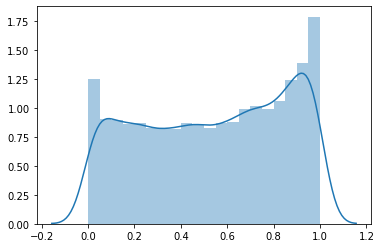

In [84]:
import seaborn as sns
ax = sns.distplot(ps)

10000


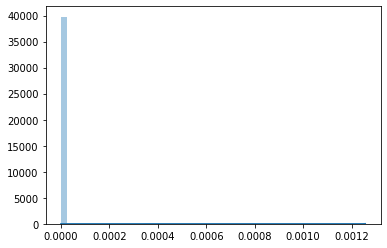

In [89]:
num = len(target_seqs)
bs_times = 100000
ps = np.zeros(bs_times)
for i in range(0,bs_times):
    _, sample_flat = bootstrap(bg_seqs,len(target_seqs))
    _, p = chisquare(sample_flat*num,f_exp=target_flat*num,ddof=14)
    ps[i]=p
print(sum(ps<0.05))
sns.distplot(ps)

In [90]:
max(ps)

0.0012566889908285572

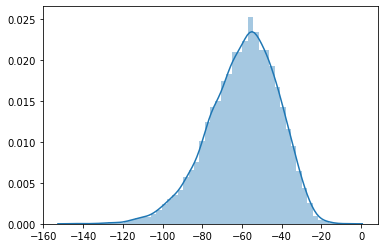

In [87]:
sns.distplot(np.log(ps)/np.log(2))

## TODO:

keep at 10000 samples, see the curve above, gather sequences at median, 1 std away (3 points in total)
produce seqlogos for points here